In this notebook, we train a probabilistic SOM model with a continuous N(0,I) latent space. 

In [1]:
from google.colab import drive
drive.mount("/content/drive",force_remount=True)

Mounted at /content/drive


In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Jun  2 16:42:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os 
os.chdir('drive/MyDrive/OASIS_Data')

In [4]:
import copy 
import time
import datetime
import numpy as np 
import pandas as pd 
import nibabel as nib
import sklearn as skl
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [5]:
import torch 
from torch.utils.data import Dataset, DataLoader
from torch import nn 
from torch import optim

In [6]:
pip install torchio nilearn

     |████████████████████████████████| 153kB 2.9MB/s 
     |████████████████████████████████| 3.1MB 12.8MB/s 
     |████████████████████████████████| 42.5MB 108kB/s 


In [7]:
import torchio as tio 

In [8]:
os.chdir("MRI_SOMVAE")
from OASISDataset import *
from FullModels import *
from TrainingTesting import *
from ExtraMetrics import *
from RegularSOM import *
from plotting_tools import *
os.chdir("..")

Split data into train and val 

In [9]:
fulltrainlist = pd.read_csv("oasis_ctrl_training.csv")

trainlist,vallist = train_test_split(fulltrainlist, random_state=128, test_size=0.15)

folder = "ctrl_original_resolution"

In [10]:
start = time.time()
traindataset = OASISDataset_Colab(folder,trainlist)
print(time.time()-start)
valdataset = OASISDataset_Colab(folder,vallist)
print(time.time()-start)

322.98081970214844
376.1606731414795


In [11]:
batch_size=32

train_dataloader = DataLoader(traindataset,batch_size=batch_size,shuffle=True)
val_dataloader = DataLoader(valdataset,batch_size=len(valdataset),shuffle=True)

Load Regular VAE for weight and K means codebook initiailization 




In [12]:
VAEcheckpoint = torch.load("VanillaVAE32_250epochs.tar")
RegularVAE = VanillaVAE(num_channels = 1,num_filters = 4,embedding_dim = 32)
RegularVAE.load_state_dict(VAEcheckpoint["model_state_dict"])
RegularVAE.eval()

VanillaVAE(
  (encoder_mu): VQEncoder(
    (conv1): Sequential(
      (0): Conv3d(1, 4, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv2): Sequential(
      (0): Conv3d(4, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv3): Sequential(
      (0): Conv3d(8, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv4): Sequential(
      (0): Conv3d(16, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    )
  )
  (encoder_sigma): VQEncoder(
    (conv1): Sequential(
      (0): Conv3d(1, 4, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv2): Sequential(
      (0): Conv3d(4, 8, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv3): Sequential(
      (0): Conv3d(8, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
      (1): ReLU()
    )
    (conv4

Initialize PSOM model 

In [13]:
PSOMVAECont = PSOMVAEContinuous(num_channels=1,num_filters=4,embedding_dim=32,num_embeddings=256,som_h=16,som_w=16,gamma=1,beta=1,geometry="toroid",batchnorm=True)

In [14]:
PSOMVAECont.encoder_mu = copy.deepcopy(RegularVAE.encoder_mu)
PSOMVAECont.encoder_sigma = copy.deepcopy(RegularVAE.encoder_sigma)
PSOMVAECont.decoder = copy.deepcopy(RegularVAE.decoder)

In [16]:
PSOMVAECont.quantization._embedding.weight

Parameter containing:
tensor([[ 0.2194,  1.3933, -0.7202,  ...,  0.2749,  0.1416,  0.7154],
        [ 0.1787, -1.1832,  0.7444,  ...,  0.8649, -0.2053, -0.5624],
        [-1.0721, -0.7343,  0.7308,  ..., -0.8006,  0.9715,  0.8372],
        ...,
        [-0.2953, -1.0958, -0.6153,  ...,  0.7256, -2.3395, -1.1823],
        [-0.0124, -0.7017,  1.2737,  ...,  0.8735,  1.1445,  0.6323],
        [ 0.9423, -0.2658, -0.4238,  ...,  0.4351,  0.4406, -0.6590]],
       requires_grad=True)

In [ ]:
#No codebook initialization this time

In [20]:
optimizer = optim.Adam(PSOMVAECont.parameters(),lr=0.005) 

max_epochs = 800
train_losses = np.zeros(max_epochs)
train_losses[:] = np.NaN 
val_losses = np.zeros(max_epochs)
val_losses[:] = np.NaN 

train_PSNR = copy.deepcopy(train_losses)
val_PSNR = copy.deepcopy(val_losses)

train_SSIM = copy.deepcopy(train_losses)
val_SSIM = copy.deepcopy(val_losses)

loss_function = nn.MSELoss(reduction="mean")

In [21]:
for epoch in range(max_epochs):

  t0 = time.time()

  train_losses[epoch] = train(PSOMVAECont,optimizer,loss_function,train_dataloader, epoch)

  val_losses[epoch] = test(PSOMVAECont,loss_function,val_dataloader)

  dtepoch = time.time() - t0

  print('====> Total time elapsed for this epoch: {:s}'.format(str(datetime.timedelta(seconds=int(dtepoch)))))

  if (epoch + 1) % 80 == 0:

    path = f"ContinuousPSOMVAE32_256_4filters_{epoch + 1}epochs_toroid_gamma1beta1_060221.tar"

    torch.save({"epoch":epoch,"model_state_dict":PSOMVAECont.state_dict(),"optimizer_state_dict": optimizer.state_dict(),"train_loss": train_losses,"val_loss":val_losses},path)

    print(f"Checkpointed at epoch {epoch + 1}")



Streaming output truncated to the last 5000 lines.
====> Begin epoch 177

Train Epoch: 177 [1/4 (25%)]	Loss: 3.185511	ET - 0:00:06

====> Epoch: 177 Average loss: 3.1171	Time elapsed: 0:00:22
====> Test set loss: 3.6198	Time elapsed: 0:00:03

====> Total time elapsed for this epoch: 0:00:25
====> Begin epoch 178

Train Epoch: 178 [1/4 (25%)]	Loss: 2.917377	ET - 0:00:06

====> Epoch: 178 Average loss: 3.0947	Time elapsed: 0:00:22
====> Test set loss: 3.6558	Time elapsed: 0:00:03

====> Total time elapsed for this epoch: 0:00:25
====> Begin epoch 179

Train Epoch: 179 [1/4 (25%)]	Loss: 3.087940	ET - 0:00:06

====> Epoch: 179 Average loss: 3.1358	Time elapsed: 0:00:22
====> Test set loss: 3.6126	Time elapsed: 0:00:03

====> Total time elapsed for this epoch: 0:00:25
====> Begin epoch 180

Train Epoch: 180 [1/4 (25%)]	Loss: 3.035010	ET - 0:00:06

====> Epoch: 180 Average loss: 3.0313	Time elapsed: 0:00:22
====> Test set loss: 3.5888	Time elapsed: 0:00:03

====> Total time elapsed for this 

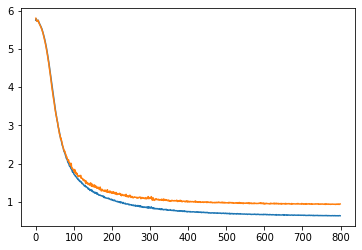

In [22]:
plt.plot(np.log(train_losses))
plt.plot(np.log(val_losses))
plt.show()

In [25]:
temp_trainSSIM = []
temp_trainPSNR = []
temp_valSSIM = []
temp_valPSNR = []


with torch.no_grad():
      use_cuda = torch.cuda.is_available()
      device = torch.device("cuda:0" if use_cuda else "cpu")
      torch.backends.cudnn.benchmark = True
      if use_cuda:
        if torch.cuda.device_count() > 1:
          print("Let's use", torch.cuda.device_count(), "GPUs!")
          # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
          PSOMVAECont = nn.DataParallel(PSOMVAECont) #NewVQVAE = nn.DataParallel(NewVQVAE)
      PSOMVAECont.to(device)#NewVQVAE.to(device)
      PSOMVAECont.eval()#NewVQVAE.eval()
      for Xin_train,Xout_train in train_dataloader:
          Xin_train,Xout_train = Xin_train.to(device), Xout_train.to(device)
          Xrecon_train = PSOMVAECont(Xin_train)["x_out"]#NewVQVAE(Xin_train)["x_out_ze"]
          train_psnr_batch = PSNR(Xout_train,Xrecon_train)
          temp_trainPSNR.append(train_psnr_batch)
          #if epoch % 2 == 0:
          train_ssim_batch = SSIM(Xout_train,Xrecon_train)
          temp_trainSSIM.append(train_ssim_batch)

      
      for Xin_val,Xout_val in val_dataloader:
          Xin_val,Xout_val = Xin_val.to(device),Xout_val.to(device)
          Xrecon_val = PSOMVAECont(Xin_val)["x_out"] #NewVQVAE(Xin_val)["x_out_ze"]
          val_psnr_batch = PSNR(Xout_val,Xrecon_val)
          temp_valPSNR.append(val_psnr_batch)
          #if epoch % 2 ==0:
          val_ssim_batch = SSIM(Xout_val,Xrecon_val)
          temp_valSSIM.append(val_ssim_batch)

In [26]:
trainSSIM = torch.cat(temp_trainSSIM).mean()
print(trainSSIM)

valSSIM = torch.cat(temp_valSSIM).mean()
print(valSSIM)

trainPSNR = torch.cat(temp_trainPSNR).mean()
print(trainPSNR)

valPSNR = torch.cat(temp_valPSNR).mean()
print(valPSNR)

tensor(0.6171, device='cuda:0')
tensor(0.6242, device='cuda:0')
tensor(19.9102, device='cuda:0')
tensor(20.6262, device='cuda:0')


In [28]:
torch.save({"epoch":epoch,"model_state_dict":PSOMVAECont.state_dict(),"optimizer_state_dict": optimizer.state_dict(),"train_loss": train_losses,"val_loss":val_losses,"trainSSIM":trainSSIM,
            "valSSIM":valSSIM,"trainPSNR":trainPSNR,"valPSNR":valPSNR},
           "ContinuousPSOMVAE32_256_4filters_800epochs_toroid_gamma1beta1_060221.tar")


In [29]:

def MoranScore(SOMmodel):
    codebook = SOMmodel.quantization._embedding.weight.detach().cpu().numpy()
    som_h = SOMmodel.quantization._som_h
    som_w = SOMmodel.quantization._som_w
    idx_to_coord = SOMmodel.quantization.idx_to_coord

    N = codebook.shape[0]
    #codebook = SS.fit_transform(codebook)
    codebook = codebook.sum(axis=1,keepdims=True)
    #codebook = codebook[:,10].reshape(N,1)
    codebook_mean = codebook.mean(axis=0,keepdims=True)

    centered_codebook = codebook - codebook_mean

    XXT = np.matmul(centered_codebook,centered_codebook.T)

    W_ij = np.zeros(XXT.shape) #weight matrix

    for i in range(codebook.shape[0]):
        for j in range(codebook.shape[0]):
            hi,wi = idx_to_coord[i] #hi and wj here are coordinates of SOM grid
            hj,wj = idx_to_coord[j]
            som_dist = np.abs(hj-hi) + np.abs(wj-wi)
            W_ij[i,j] = np.exp(-som_dist)

    XXT_diag = np.diag(XXT)
    W = np.sum(W_ij)

    I_Moran = N/W * (np.sum(W_ij * XXT))/(np.sum(XXT_diag))

    return(I_Moran)

In [31]:
codebook = PSOMVAECont.quantization._embedding.weight.detach().cpu().numpy()
codebook_grid = codebook.reshape(16,16,-1)

In [33]:
codebook_grid[5,5]

array([-2.7552989,  2.2292442,  3.140022 , -3.426724 , -2.5486052,
        2.0368419, -1.9244717, -1.8211559, -2.6041238,  2.6198661,
       -1.2892038, -1.8777044,  2.3403077, -3.1217859, -3.2960873,
        2.339364 ,  2.838641 , -2.3645666, -0.9112866,  2.003015 ,
       -2.0406945, -3.338729 ,  2.4252043, -1.7830627, -3.759942 ,
        1.7038314,  2.6831913, -2.982477 , -2.312488 ,  2.0844157,
       -2.344205 , -2.0263293], dtype=float32)

In [34]:
codebook_grid[5,6]

array([-1.8699621 ,  2.1118827 , -2.9957128 , -0.37100646,  3.79562   ,
        2.4855428 ,  2.9200807 , -2.0417764 , -2.0592422 , -1.0871087 ,
        1.595866  , -2.7296386 , -2.0328324 , -2.4082198 , -3.0176063 ,
       -2.7313936 , -0.8971029 ,  4.6547413 ,  0.59044594,  2.7630916 ,
        2.444161  ,  2.8551774 ,  0.1832522 ,  2.203881  , -2.7153661 ,
       -3.218724  , -2.3862302 , -1.7180928 , -1.0291517 ,  1.4578284 ,
       -3.2794485 ,  2.723931  ], dtype=float32)

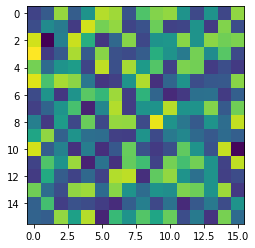

In [35]:
plt.imshow(codebook_grid[:,:,14])
plt.show()

In [37]:
MoranScore(PSOMVAECont)

0.24047864163461

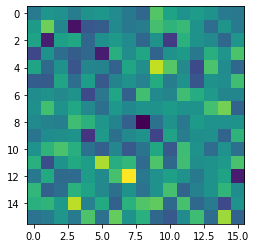

In [38]:
plt.imshow(codebook.sum(axis=1).reshape(16,16))
plt.show()